In [13]:
!pip install pyarrow


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [14]:
import numpy as np
import pandas as pd
import os
import sys
import pyarrow.parquet as pq
import re
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pytz
import math
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [15]:
def compute_portfolio_metrics(monthly_returns, hold_period):
    """

    Args:
    - returns (array-like): Array or list of portfolio returns

    Returns:
    - sharpe_ratio (float): Sharpe ratio of the portfolio
    - max_drawdown (float): Maximum drawdown of the portfolio
    - hit_rate (float): Hit rate of the portfolio (percentage of positive returns)
    """
    monthly_returns = monthly_returns/100
    # Calculate Sharpe Ratio
    annualized_returns = monthly_returns.mean() * 12/hold_period
    annualized_volatility = monthly_returns.std() * np.sqrt(12/hold_period)
    sharpe_ratio = annualized_returns / annualized_volatility

    # Maximum Drawdown
    cumulative_returns = (1 + monthly_returns).cumprod()
    peak_value = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak_value) / peak_value
    max_drawdown = drawdown.min()

    # Hit Rate
    positive_returns = monthly_returns[monthly_returns > 0]
    hit_rate = len(positive_returns) / len(monthly_returns)

    # Compound Annual Growth Rate (CAGR)
    total_return = cumulative_returns.iloc[-1] - 1
    num_years = len(monthly_returns)*hold_period/12
    cagr = ((1 + total_return) ** (1 / num_years) - 1)*100
    monthly_ret = int(monthly_returns.mean()*10000)
    monthly_vol = int(monthly_returns.std()*10000)

    metrics_dict = {
        'Sharpe Ratio': sharpe_ratio.round(2),
        'Max Drawdown': max_drawdown.round(2),
        'Hit Rate': str(int(hit_rate*100))+'%',
        'CAGR': str(cagr.round(2))+'%',
        'Monthly Returns': str(monthly_ret)+'bps' ,
        'Monthly Vol': str(monthly_vol)+'bps'
    }
    metrics_dict = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
    return metrics_dict

def plot_returns(monthly_returns, dates):
    """
    Plot monthly returns and cumulative returns.

    Parameters:
    - monthly_returns: Pandas Series or DataFrame with monthly portfolio returns.

    Returns:
    - None
    """
    monthly_returns = monthly_returns/100
    # Calculate cumulative returns
    cumulative_returns = (1 + monthly_returns).cumprod() - 1

    # Plot monthly returns
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(dates, monthly_returns, color='blue', label='Monthly Returns')
    plt.ylabel('Returns')
    plt.title('Monthly Returns')
    plt.yticks(color= 'red')

    # Plot cumulative returns
    plt.subplot(2, 1, 2)
    plt.plot(dates, cumulative_returns, color='green', label='Cumulative Returns')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns')

    plt.tight_layout()
    plt.show()
def plot_long_short_cumm_returns(long_ret, short_ret, dates, title = None):
    long_ret = long_ret/100
    short_ret = short_ret/100
    ret = long_ret - short_ret

    #long_cum_ret = (1 + long_ret).cumprod() - 1
    #short_cum_ret = (1 + short_ret).cumprod() - 1
    long_cum_ret = long_ret.cumsum()
    short_cum_ret = short_ret.cumsum()
    port_ret = ret.cumsum()
    #port_ret2 = long_cum_ret - short_cum_ret

    #Plot cumulative returns
    plt.figure(figsize=(20, 10))
    #plt.plot(dates, port_ret2, color='green', linestyle = ':', label='Cumulative Returns1')
    plt.plot(dates, port_ret, color = 'black', linestyle = '-', label = 'Cumulative Returns')
    plt.plot(dates, long_cum_ret, color = 'black', linestyle = 'dashed', label = 'Long Portfolio')
    plt.plot(dates, short_cum_ret, color = 'black', linestyle = '-.', label = 'Short Portfolio')
    plt.ylabel('Cumulative Returns')
    plt.title(f'Cumulative Returns {title}')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def get_SPY_returns(start, end):
    end = end + relativedelta(months=1)
    SP500 = yf.download('^GSPC', start=start, end=end)['Adj Close']
    monthly_prices = SP500.resample('M').agg(['first', 'last']).reset_index()
    monthly_prices['Return'] = (monthly_prices['last'] / monthly_prices['first'] - 1)
    monthly_prices['Cumm_Return'] = monthly_prices['Return'].cumsum()
    return monthly_prices

def get_returns(long_ret, short_ret, dates):
    long_ret = long_ret/100
    short_ret = short_ret/100
    ret = long_ret - short_ret

    #long_cum_ret = (1 + long_ret).cumprod() - 1
    #short_cum_ret = (1 + short_ret).cumprod() - 1
    long_cum_ret = long_ret.cumsum()
    short_cum_ret = short_ret.cumsum()
    port_ret = ret.cumsum()
    sp500_ret = get_SPY_returns(dates.iloc[0], dates.iloc[-1])
    #port_ret2 = long_cum_ret - short_cum_ret

    return sp500_ret, port_ret

In [16]:
def get_monthly_returns(port_returns, hold_period):
    port_returns = port_returns.copy(deep = True)
    # Find columns containing 'return' substring
    return_columns = [col for col in port_returns.columns if 'long_return' in col.lower() or 'short_return' in col.lower()]
    total_return_columns = set([col.replace('long_', '').replace('short_', '') for col in return_columns])
    #print(total_return_columns)
    for col in return_columns:
        #print(col)
        port_returns[col] = port_returns[col].apply(lambda x: ((1+x/100)**(1/hold_period) - 1)*100)
    for col in total_return_columns:
        port_returns[col] = port_returns['long_' + col] - port_returns['short_' + col]
    return port_returns

In [17]:
month_dict = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
folder_path = r'/data/workspace_files/parquet_files'

In [22]:
for sim_score in ['cosine_similarity', 'jaccard_similarity']:
    res_table = []
    for lead in range(1,13):
        for num_bucket in [5]:
            file_path_req = f'{folder_path}/portfolio_lead_lag/{sim_score}/{lead}/LS/ret.parquet'
            portfolio = pq.read_table(file_path_req).to_pandas()
            res = compute_portfolio_metrics(portfolio['return_clipped'], 1)
            res_table.append(res)
    res_table = pd.concat(res_table, axis = 1)
    res_table.columns = ['Lead = ' + str(x) for x in range(1,13)]
    display(res_table)

,Lead = 1,Lead = 2,Lead = 3,Lead = 4,Lead = 5,Lead = 6,Lead = 7,Lead = 8,Lead = 9,Lead = 10,Lead = 11,Lead = 12
Sharpe Ratio,2.63,2.45,2.83,2.23,1.96,2.26,1.69,1.15,2.09,2.38,1.6,2.69
Max Drawdown,-0.09,-0.11,-0.04,-0.15,-0.09,-0.14,-0.18,-0.26,-0.11,-0.12,-0.16,-0.18
Hit Rate,76%,75%,81%,76%,72%,73%,64%,64%,72%,75%,70%,81%
CAGR,9.34%,8.89%,9.93%,8.01%,6.06%,7.76%,5.66%,4.24%,6.89%,8.94%,5.64%,9.64%
Monthly Returns,75bps,71bps,79bps,64bps,49bps,62bps,46bps,35bps,56bps,72bps,46bps,77bps
Monthly Vol,98bps,101bps,97bps,100bps,87bps,96bps,95bps,106bps,93bps,104bps,100bps,99bps


,Lead = 1,Lead = 2,Lead = 3,Lead = 4,Lead = 5,Lead = 6,Lead = 7,Lead = 8,Lead = 9,Lead = 10,Lead = 11,Lead = 12
Sharpe Ratio,3.88,2.83,3.22,3.1,2.23,3.04,2.7,1.71,3.11,2.76,2.36,3.3
Max Drawdown,-0.04,-0.08,-0.05,-0.06,-0.09,-0.05,-0.14,-0.17,-0.07,-0.12,-0.13,-0.1
Hit Rate,85%,79%,83%,82%,75%,82%,76%,69%,80%,76%,78%,85%
CAGR,14.16%,12.05%,12.41%,12.2%,8.38%,11.02%,10.68%,6.07%,12.58%,11.15%,9.62%,12.56%
Monthly Returns,111bps,95bps,98bps,96bps,67bps,87bps,85bps,49bps,99bps,89bps,77bps,99bps
Monthly Vol,99bps,117bps,105bps,108bps,105bps,100bps,109bps,100bps,111bps,111bps,113bps,104bps


In [19]:
portfolio

,date,return,return_clipped,return_clipped2,num_holdings,long_return,long_return_clipped,long_return_clipped2,short_return,short_return_clipped,short_return_clipped2
0,1996-05-01,5.417290,2.718200,2.920339,920,4.258915,1.523643,1.914933,-1.158376,-1.194557,-1.005406
1,1996-06-01,4.995446,2.513041,2.568003,1002,2.945612,0.430040,0.629206,-2.049834,-2.083000,-1.938797
2,1996-07-01,2.185195,1.676197,1.684502,1093,1.063345,0.406446,0.544039,-1.121850,-1.269751,-1.140463
3,1996-08-01,1.191690,1.151996,1.078238,1579,2.200481,1.945307,1.998780,1.008790,0.793311,0.920542
4,1996-09-01,1.402625,1.481497,1.430885,1647,2.273211,2.010268,2.090276,0.870587,0.528771,0.659391
...,...,...,...,...,...,...,...,...,...,...,...
255,2017-08-01,0.538239,0.604084,0.534979,3245,3.401541,2.752214,3.009196,2.863302,2.148130,2.474216
256,2017-09-01,-0.065394,0.218011,0.025319,2928,3.810304,3.070107,3.489417,3.875698,2.852096,3.464097
257,2017-10-01,0.172073,0.306866,0.097269,2875,4.345298,3.508034,3.876963,4.173225,3.201168,3.779695
258,2017-11-01,0.608516,-0.849533,-1.190503,2817,3.935217,1.181756,1.618282,3.326701,2.031289,2.808785


Running for section: business, lookback_period: 3, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: risk, lookback_period: 3, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: qmr, lookback_period: 3, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: mda, lookback_period: 3, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: business, lookback_period: 6, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: risk, lookback_period: 6, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: qmr, lookback_period: 6, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: mda, lookback_period: 6, num_bucket: 5
[*********************100

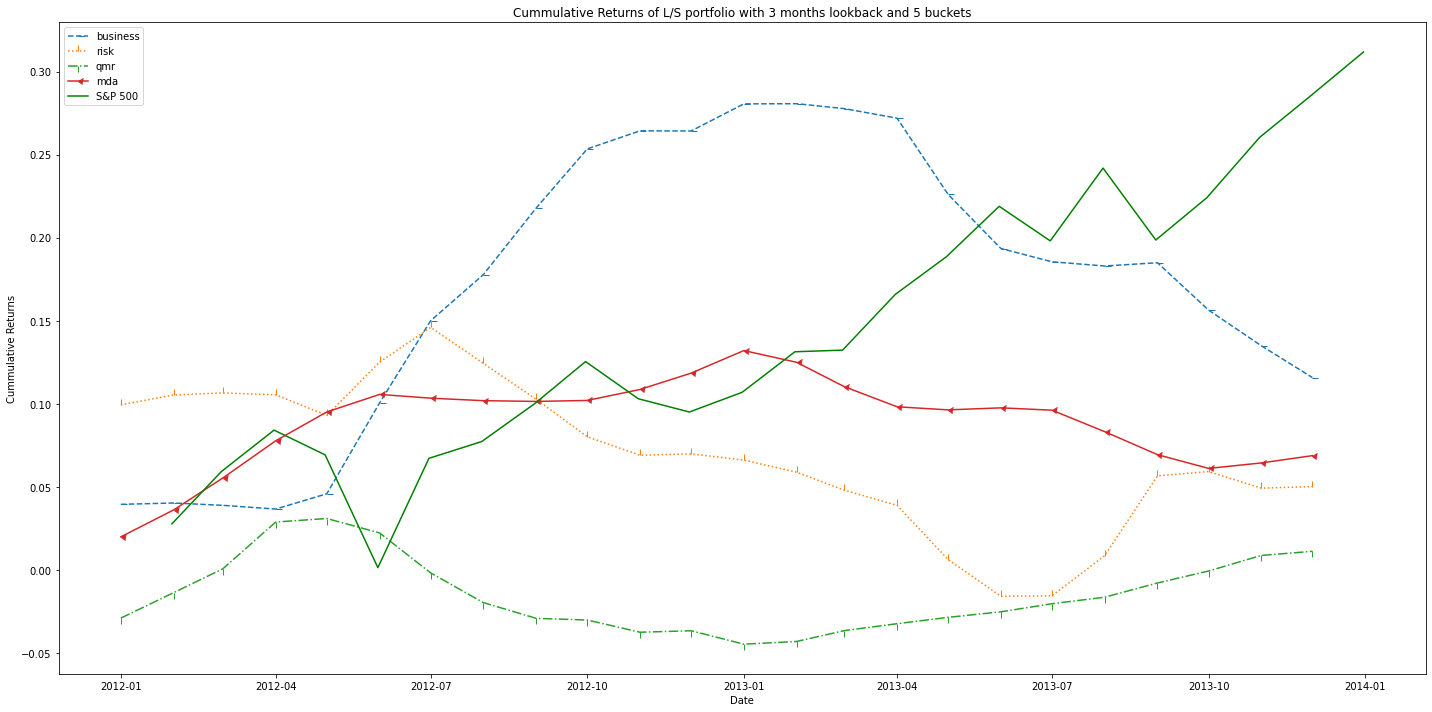

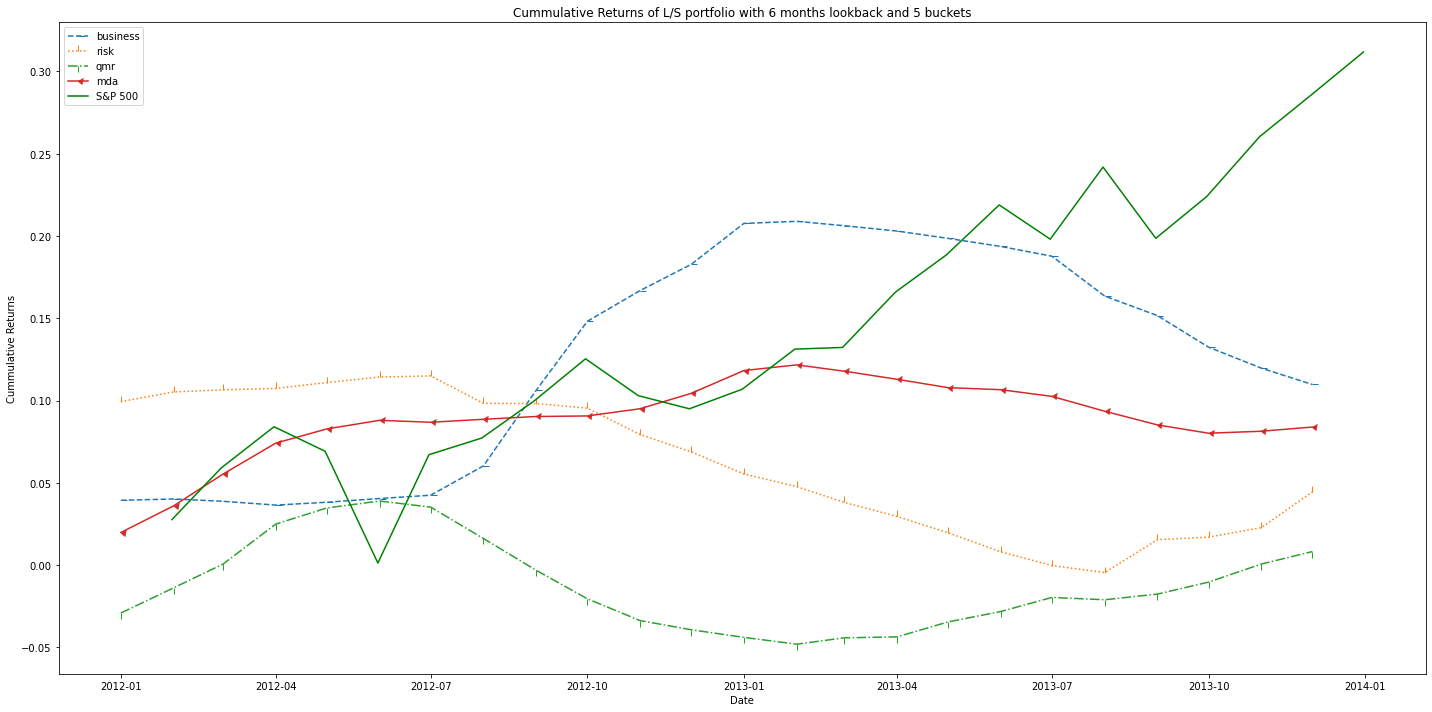

In [12]:
sim_score = 'cosine_similarity'
start_date = '2012-01-01'
end_date = '2013-12-31'
for history in [3,6]:
    for num_bucket in [5]:
        plt.figure(figsize=(20, 10))
        linestyle = ['--', ':', '-.', '-']
        markers = [1,2,3,4,5]
        for section in ['business', 'risk', 'qmr', 'mda']:
            file_path_req = f'{folder_path}/port_rets_n_scores/SP/{sim_score}/{section}/h_{history}/n_{num_bucket}/ret.parquet'
            portfolio = pq.read_table(file_path_req).to_pandas()
            portfolio = portfolio[(portfolio['date'] >= start_date) & (portfolio['date'] <= end_date)]
            print(f"Running for section: {section}, lookback_period: {history}, num_bucket: {num_bucket}")
            dates = portfolio['date']
            sp500_ret, port_ret = get_returns(portfolio['long_return_clipped'], portfolio['short_return_clipped'], portfolio['date'])
            plt.plot(dates, port_ret, label = section, linestyle = linestyle.pop(0), marker = markers.pop(0))
        plt.plot(sp500_ret['Date'], sp500_ret['Cumm_Return'],color = 'green', linestyle = '-', label = 'S&P 500')
        plt.ylabel('Cummulative Returns')
        plt.xlabel('Date')
        plt.legend()
        plt.title(f'Cummulative Returns of L/S portfolio with {history} months lookback and {num_bucket} buckets')

        plt.tight_layout()
        plt.show()

In [10]:
sim_score = 'cosine_similarity'
start_date = '2012-01-01'
end_date = '2013-12-31'
for history in [3,6]:
    for num_bucket in [5]:
        res_table = []
        for section in ['business', 'risk', 'qmr', 'mda']:
            file_path_req = f'{folder_path}/port_rets_n_scores/SP/{sim_score}/{section}/h_{history}/n_{num_bucket}/ret.parquet'
            portfolio = pq.read_table(file_path_req).to_pandas()
            portfolio = portfolio[(portfolio['date'] >= start_date) & (portfolio['date'] <= end_date)]
            print(f"Running for section: {section}, lookback_period: {history}, num_bucket: {num_bucket}")
            dates = portfolio['date']
            sp500_ret, port_ret = get_returns(portfolio['long_return_clipped'], portfolio['short_return_clipped'], portfolio['date'])
            res = compute_portfolio_metrics(portfolio['return_clipped'], 1)
            res_table.append(res)
        res = compute_portfolio_metrics(sp500_ret['Return'], 1)
        res_table.append(res)
        res_table = pd.concat(res_table, axis = 1)
        res_table.columns = ['Business', 'Risk', 'QMR', 'MDA', 'S&P 500']
        display(res_table)

Running for section: business, lookback_period: 3, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: risk, lookback_period: 3, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: qmr, lookback_period: 3, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: mda, lookback_period: 3, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: business, lookback_period: 6, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: risk, lookback_period: 6, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: qmr, lookback_period: 6, num_bucket: 5
[*********************100%***********************]  1 of 1 completed
Running for section: mda, lookback_period: 6, num_bucket: 5
[*********************100

,Business,Risk,QMR,MDA,S&P 500
Sharpe Ratio,0.64,0.26,0.13,0.88,1.52
Max Drawdown,-0.15,-0.15,-0.07,-0.07,-0.0
Hit Rate,50%,45%,66%,54%,75%
CAGR,5.54%,2.1%,0.47%,3.42%,0.16%
Monthly Returns,48bps,20bps,4bps,28bps,1bps
Monthly Vol,259bps,278bps,125bps,113bps,2bps


,Business,Risk,QMR,MDA,S&P 500
Sharpe Ratio,0.85,0.28,0.09,1.38,1.52
Max Drawdown,-0.1,-0.11,-0.08,-0.04,-0.0
Hit Rate,50%,45%,58%,62%,75%
CAGR,5.42%,1.95%,0.32%,4.23%,0.16%
Monthly Returns,45bps,18bps,3bps,34bps,1bps
Monthly Vol,185bps,229bps,127bps,87bps,2bps


In [7]:
portfolio

,date,return,return_clipped,return_clipped2,num_holdings,long_return,long_return_clipped,long_return_clipped2,short_return,short_return_clipped,short_return_clipped2
0,2012-01-01,1.984400,1.984400,1.984400,12,8.275850,8.275850,8.275850,6.291450,6.291450,6.291450
1,2012-02-01,1.619685,1.619685,1.436651,127,3.232110,3.232110,3.212360,1.612425,1.612425,1.775709
2,2012-03-01,1.928393,1.928393,1.783552,143,3.096500,3.096500,3.078976,1.168107,1.168107,1.295424
3,2012-04-01,1.882906,1.882906,1.780233,167,1.149328,1.149328,1.113976,-0.733578,-0.733578,-0.666258
4,2012-05-01,0.862803,0.862803,0.689878,225,1.561430,1.561430,1.561430,0.698627,0.698627,0.871552
...,...,...,...,...,...,...,...,...,...,...,...
103,2020-08-01,-0.682631,-0.682631,-0.596608,218,1.134932,1.134932,1.134932,1.817562,1.817562,1.731539
104,2020-09-01,-0.357364,-0.357364,-0.226208,213,0.680492,0.680492,0.680492,1.037856,1.037856,0.906700
105,2020-10-01,-0.305384,-0.305384,-0.441876,219,4.632752,4.632752,4.568641,4.938135,4.938135,5.010517
106,2020-11-01,-0.400338,-0.400338,-0.502719,203,6.732124,6.732124,6.641860,7.132461,7.132461,7.144579


In [15]:
file_path_req

'/data/workspace_files/parquet_files/F_and_H/f6_and_h6/n_10/jaccard_similarity/ret.parquet'

In [17]:
pq.read_table(file_path_req).to_pandas()

,date,return,return_clipped,return_clipped2,num_holdings,long_return,long_return_clipped,long_return_clipped2,short_return,short_return_clipped,short_return_clipped2
0,1996-05-01,57.039991,9.363566,10.373601,459,59.668566,9.318869,13.042194,2.628575,-0.044697,2.668594
1,1996-11-01,4.465846,3.478044,3.502492,911,13.452663,9.177013,11.120479,8.986817,5.698969,7.617987
2,1997-05-01,-0.653850,2.807308,2.755498,1228,25.162085,17.495906,23.357188,25.815936,14.688598,20.601690
3,1997-11-01,18.908808,7.741656,9.462401,1792,23.679682,9.990062,13.763799,4.770874,2.248406,4.301398
4,1998-05-01,17.202105,5.654389,7.391039,1777,1.795497,-10.871674,-9.982402,-15.406608,-16.526062,-17.373441
5,1998-11-01,43.341175,3.643568,8.701677,1855,58.714803,4.730284,16.671042,15.373628,1.086715,7.969366
6,1999-05-01,5.215093,2.723195,4.860188,1818,15.139807,3.162133,13.112655,9.924714,0.438937,8.252468
7,1999-11-01,30.487305,1.275512,11.543433,1844,52.614923,2.882132,32.260011,22.127618,1.606620,20.716578
8,2000-05-01,10.137756,7.219945,8.848773,1768,2.280996,-1.266006,0.822395,-7.856759,-8.485951,-8.026378
9,2000-11-01,3.203831,5.928761,4.417192,1750,6.507268,4.130052,5.945890,3.303438,-1.798710,1.528698


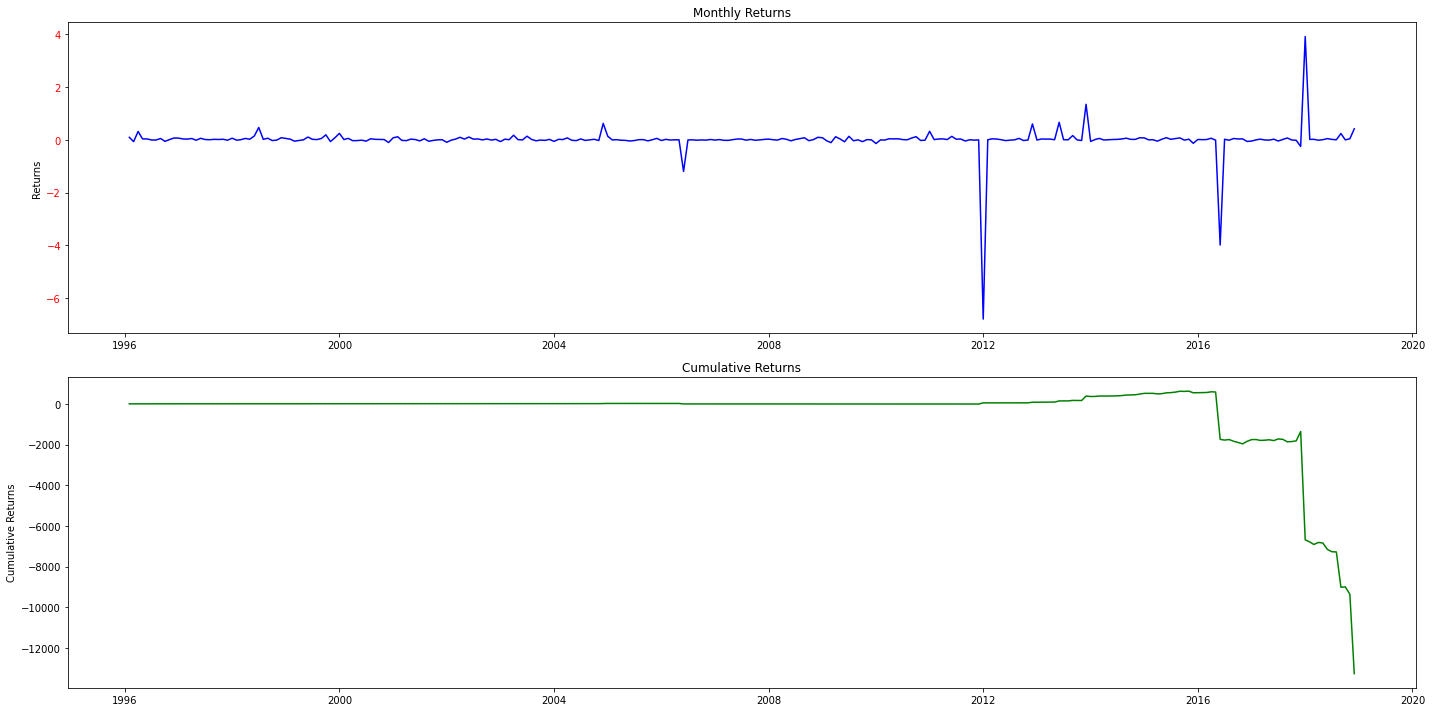

In [58]:
plot_returns(portfolio['return_clipped2'], portfolio['date'])

In [42]:
cos_sim = pq.read_table('/data/workspace_files/parquet_files/portfolio_returns/1996_2014/cosine_similarity_LS_ew.parquet').to_pandas()
start_date = pd.Timestamp('1997-01-01')
cos_sim = cos_sim[cos_sim['date']>=start_date]

## Cosine Similarity

,Value
Sharpe Ratio,1.47
Max Drawdown,-0.14
Hit Rate,73%
CAGR,7.96%
Monthly Returns,65bps
Monthly Vol,154bps


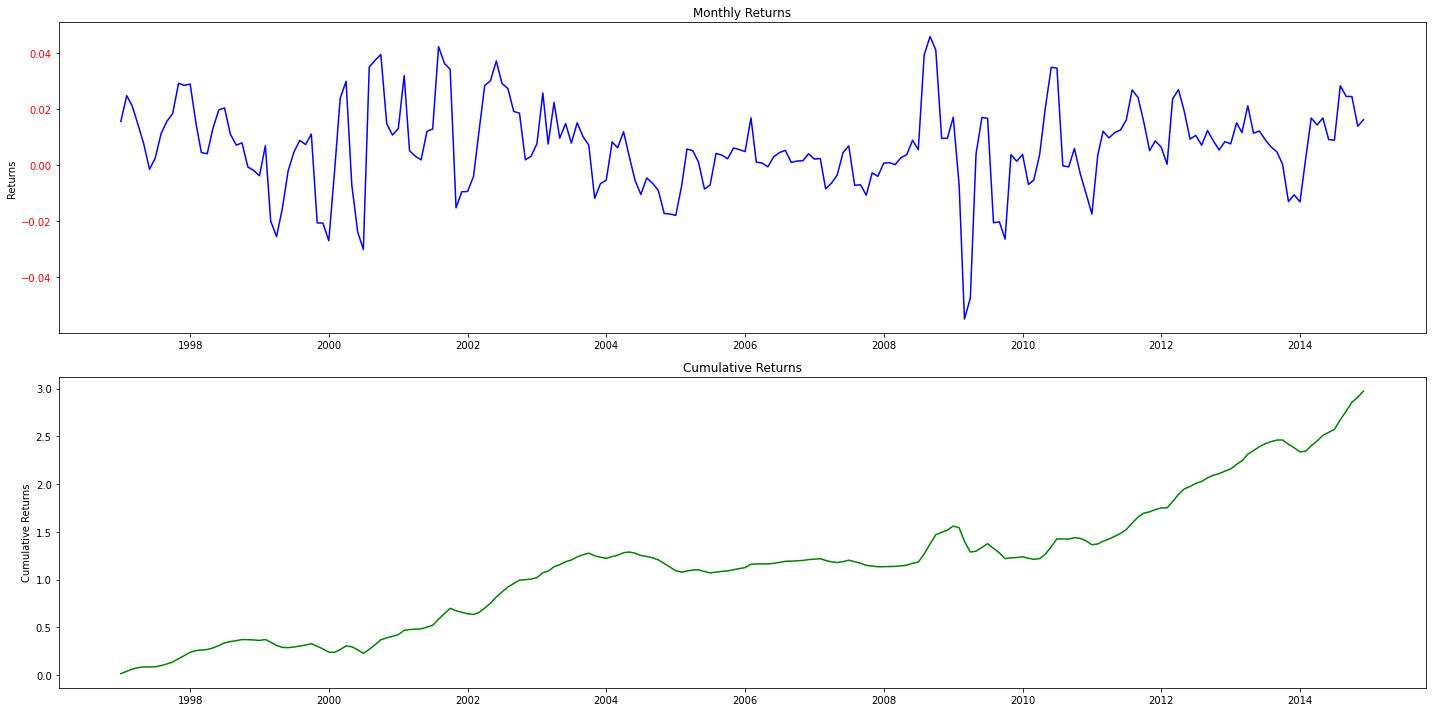

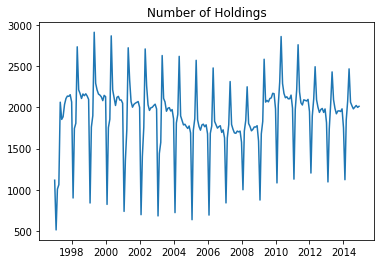

In [44]:
display(compute_portfolio_metrics(cos_sim['return_clipped2'], 1))
plot_returns(cos_sim['return_clipped2'], cos_sim['date'])
plt.plot(cos_sim['date'], cos_sim['num_holdings'])
plt.title('Number of Holdings')
plt.show()

In [21]:
jac_sim_vw = pq.read_table('/data/workspace_files/parquet_files/portfolio_returns/1996_2014/cosine_similarity_LS_vw.parquet').to_pandas()
jac_sim_vw = jac_sim_vw[jac_sim_vw['date']>=start_date]
display(compute_portfolio_metrics(jac_sim_vw['return_clipped2']))
plot_returns(jac_sim_vw['return_clipped2'], jac_sim_vw['date'])
plt.plot(jac_sim_vw['date'], jac_sim_vw['num_holdings'])
plt.title('Number of Holdings')
plt.show()

,Value
Sharpe Ratio,0.34
Max Drawdown,-0.91
Hit Rate,57%
CAGR,5.33%
Monthly Returns,66bps
Monthly Vol,676bps


In [18]:
jac_sim = pq.read_table('/data/workspace_files/parquet_files/portfolio_returns/1996_2014/jaccard_similarity_LS_ew.parquet').to_pandas()
jac_sim = jac_sim[jac_sim['date']>=start_date]

## Jaccard Similarity

,Value
Sharpe Ratio,2.16
Max Drawdown,-0.12
Hit Rate,74%
CAGR,13.49%
Monthly Returns,107bps
Monthly Vol,172bps


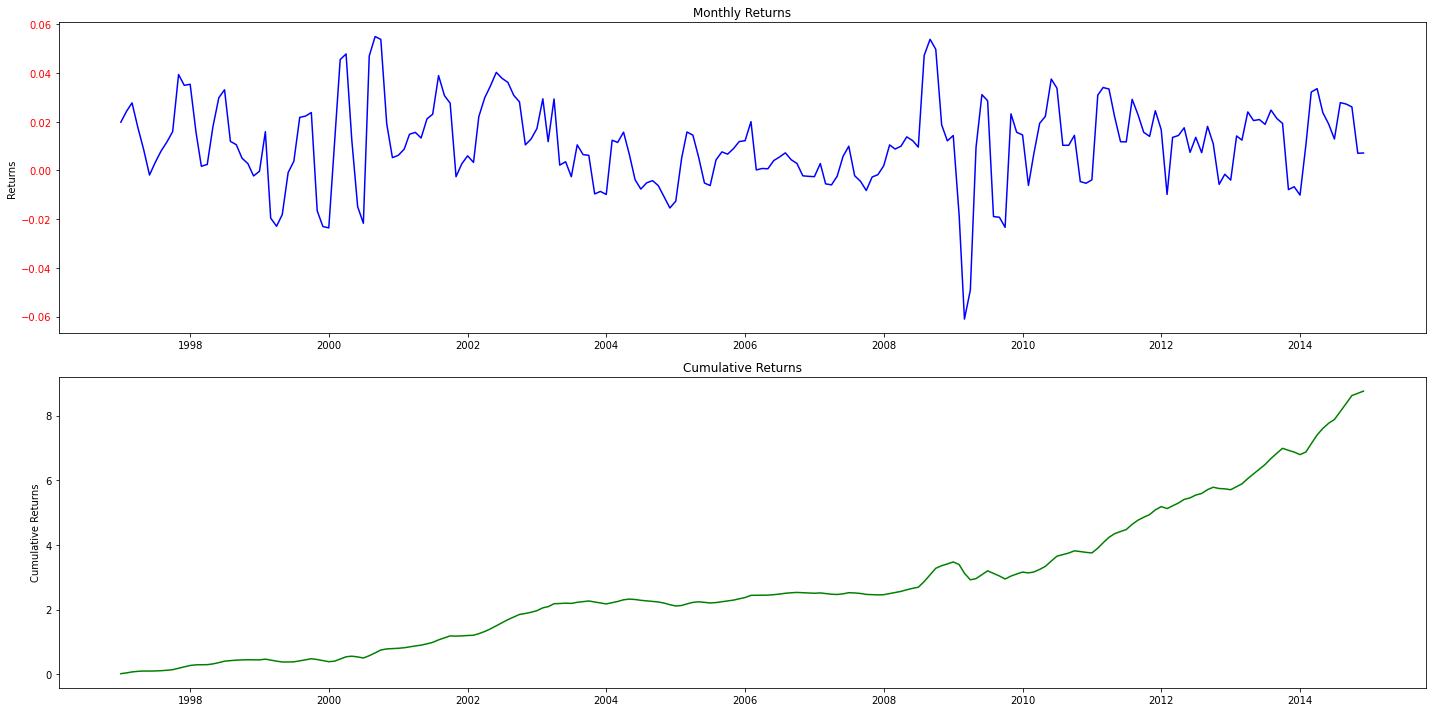

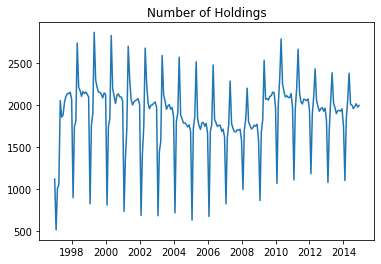

In [19]:
display(compute_portfolio_metrics(jac_sim['return_clipped2']))
plot_returns(jac_sim['return_clipped2'], jac_sim['date'])
plt.plot(jac_sim['date'], jac_sim['num_holdings'])
plt.title('Number of Holdings')
plt.show()

,Value
Sharpe Ratio,0.06
Max Drawdown,-0.96
Hit Rate,59%
CAGR,-3.58%
Monthly Returns,14bps
Monthly Vol,940bps


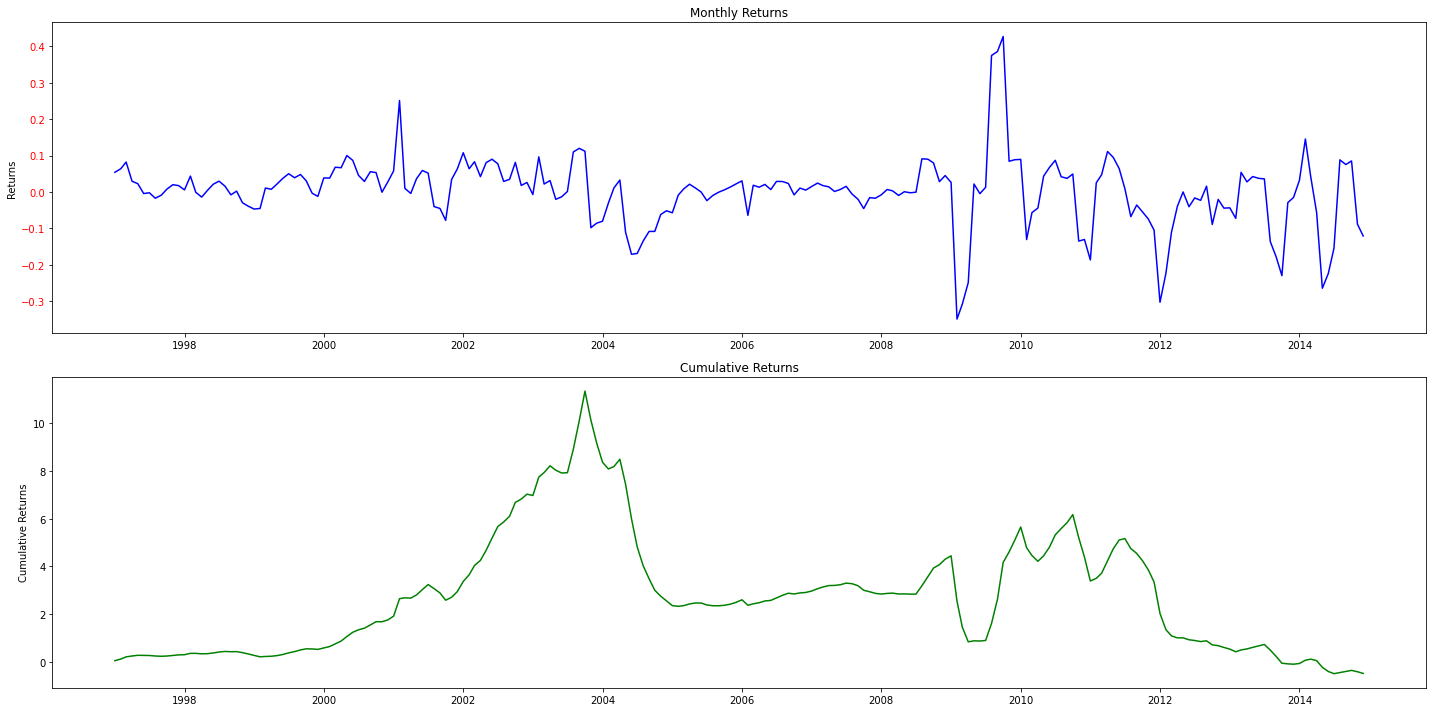

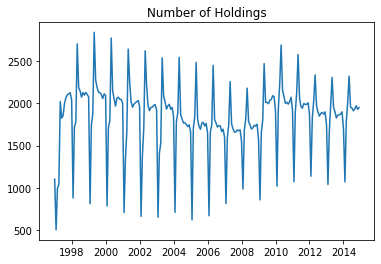

In [23]:
jac_sim_vw = pq.read_table('/data/workspace_files/parquet_files/portfolio_returns/1996_2014/jaccard_similarity_LS_vw.parquet').to_pandas()
jac_sim_vw = jac_sim_vw[jac_sim_vw['date']>=start_date]
display(compute_portfolio_metrics(jac_sim_vw['return_clipped2']))
plot_returns(jac_sim_vw['return_clipped2'], jac_sim_vw['date'])
plt.plot(jac_sim_vw['date'], jac_sim_vw['num_holdings'])
plt.title('Number of Holdings')
plt.show()

In [25]:
factor_returns = pd.read_csv('/data/workspace_files/F-F_Research_Data_5_Factors_2x3.csv')

In [26]:
factor_returns.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

In [32]:
factor_returns.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,196308,5.07,-0.8,1.8,0.36,-0.35,0.25
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,196310,2.53,-1.39,-0.1,2.8,-2.01,0.29
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27


In [30]:
factor_returns['Date'] = pd.to_datetime(factor_returns['Date'], format='%Y%m',errors='coerce')
factor_returns.dropna(subset=['Date'],inplace=True)

In [30]:
factor_returns.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,1963-08-01,5.07,-0.8,1.8,0.36,-0.35,0.25
2,1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,1963-10-01,2.53,-1.39,-0.1,2.8,-2.01,0.29
4,1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27


In [34]:
jac_sim.rename(columns={'date': 'Date'}, inplace=True)

In [35]:
len(jac_sim)

228

In [36]:
merged = pd.merge(jac_sim, factor_returns, on='Date')

In [37]:
len(merged)

228

In [37]:
merged.head()

,Date,return,return_clipped,return_clipped2,num_holdings,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2015-05-01,2.928274,3.337968,3.265861,1857,1.36,0.83,-1.14,-1.79,-0.74,0
1,2015-06-01,4.943673,3.229237,3.418876,1909,-1.53,2.9,-0.79,0.44,-1.58,0
2,2015-07-01,2.972411,2.462160,2.494371,1942,1.54,-4.55,-4.13,0.3,-2.41,0
3,2015-08-01,15.533055,4.841790,4.995128,1904,-6.04,0.25,2.77,0.68,1.19,0
4,2015-09-01,2.827844,1.353618,1.332158,1932,-3.07,-2.79,0.56,1.77,-0.58,0


In [38]:
import statsmodels.api as sm
merged['Mkt-RF'] = merged['Mkt-RF'].astype(float)
merged['SMB'] = merged['SMB'].astype(float)
merged['HML'] = merged['HML'].astype(float)
merged['RMW'] = merged['RMW'].astype(float)
merged['CMA'] = merged['CMA'].astype(float)
merged['return_clipped2'] = merged['return_clipped2'].astype(float)
merged['RF'] = merged['RF'].astype(float)

y = merged['return_clipped2']-merged['RF']
x = merged[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.872
Date:                Fri, 02 Feb 2024   Prob (F-statistic):             0.0155
Time:                        01:52:59   Log-Likelihood:                -494.19
No. Observations:                 228   AIC:                             1000.
Df Residuals:                     222   BIC:                             1021.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6872      0.152      4.532      0.0

In [39]:
x = merged[['Mkt-RF', 'SMB', 'HML']]
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.510
Date:                Fri, 02 Feb 2024   Prob (F-statistic):             0.0596
Time:                        01:54:52   Log-Likelihood:                -497.57
No. Observations:                 228   AIC:                             1003.
Df Residuals:                     224   BIC:                             1017.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7961      0.146      5.470      0.0

In [40]:
x = merged[['Mkt-RF']]
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     5.792
Date:                Fri, 02 Feb 2024   Prob (F-statistic):             0.0169
Time:                        01:54:57   Log-Likelihood:                -498.45
No. Observations:                 228   AIC:                             1001.
Df Residuals:                     226   BIC:                             1008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8103      0.144      5.608      0.0

In [41]:
jac_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             228 non-null    datetime64[ns]
 1   return           228 non-null    float64       
 2   return_clipped   228 non-null    float64       
 3   return_clipped2  228 non-null    float64       
 4   num_holdings     228 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 9.0 KB


## Quintile Portfolio Analysis

In [13]:
def compute_quintile_portfolio_metrics(score_type, ret_type = 'return_clipped2', weight_type='vw'):
    metrics = []
    for quintile in range(1,6):
        port_returns = pq.read_table(f'/data/workspace_files/parquet_files/portfolio_returns/1996_2014/{score_type}_Q{str(quintile)}_{weight_type}.parquet').to_pandas()
        monthly_returns = port_returns[ret_type]
        monthly_returns = monthly_returns/100
        # Calculate Sharpe Ratio
        annualized_returns = monthly_returns.mean() * 12
        annualized_volatility = monthly_returns.std() * np.sqrt(12)
        sharpe_ratio = annualized_returns / annualized_volatility

        # Maximum Drawdown
        cumulative_returns = (1 + monthly_returns).cumprod()
        peak_value = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak_value) / peak_value
        max_drawdown = drawdown.min()

        # Hit Rate
        positive_returns = monthly_returns[monthly_returns > 0]
        hit_rate = len(positive_returns) / len(monthly_returns)

        # Compound Annual Growth Rate (CAGR)
        total_return = cumulative_returns.iloc[-1] - 1
        num_years = len(monthly_returns) / 12
        cagr = ((1 + total_return) ** (1 / num_years) - 1)*100
        monthly_ret = int(monthly_returns.mean()*10000)
        monthly_vol = int(monthly_returns.std()*10000)

        metrics_dict = {
            'Quintile': quintile,
            'Sharpe Ratio': sharpe_ratio.round(2),
            'Max Drawdown': max_drawdown.round(2),
            'Hit Rate': str(int(hit_rate*100))+'%',
            'CAGR': str(cagr.round(2))+'%',
            'Monthly Returns': str(monthly_ret)+'bps' ,
            'Monthly Vol': str(monthly_vol)+'bps'
        }
        metrics.append(metrics_dict)
    metrics = pd.DataFrame(metrics)
    return metrics

In [5]:
compute_quintile_portfolio_metrics('cosine_similarity', weight_type='ew')

,Quintile,Sharpe Ratio,Max Drawdown,Hit Rate,CAGR,Monthly Returns,Monthly Vol
0,1,0.55,-0.49,62%,7.77%,73bps,463bps
1,2,0.59,-0.57,63%,8.71%,81bps,475bps
2,3,0.87,-0.48,64%,13.05%,112bps,451bps
3,4,0.90,-0.47,65%,12.13%,103bps,397bps
4,5,1.40,-0.40,70%,17.97%,145bps,359bps


In [6]:
compute_quintile_portfolio_metrics('jaccard_similarity', weight_type='ew')

,Quintile,Sharpe Ratio,Max Drawdown,Hit Rate,CAGR,Monthly Returns,Monthly Vol
0,1,0.36,-0.57,59%,4.78%,50bps,482bps
1,2,0.64,-0.54,64%,9.75%,89bps,479bps
2,3,0.77,-0.48,63%,10.7%,94bps,424bps
3,4,1.01,-0.46,65%,13.95%,117bps,403bps
4,5,1.57,-0.40,72%,21.22%,168bps,370bps


## Value weighted

In [14]:
compute_quintile_portfolio_metrics('cosine_similarity', weight_type='vw')

,Quintile,Sharpe Ratio,Max Drawdown,Hit Rate,CAGR,Monthly Returns,Monthly Vol
0,1,0.24,-0.90,55%,2.84%,58bps,850bps
1,2,0.18,-0.89,56%,1.2%,40bps,775bps
2,3,0.35,-0.77,55%,6.15%,86bps,862bps
3,4,0.33,-0.85,53%,5.75%,79bps,827bps
4,5,0.68,-0.74,58%,14.71%,139bps,710bps


In [15]:
compute_quintile_portfolio_metrics('jaccard_similarity', weight_type='vw')

,Quintile,Sharpe Ratio,Max Drawdown,Hit Rate,CAGR,Monthly Returns,Monthly Vol
0,1,0.17,-0.93,50%,0.47%,48bps,978bps
1,2,0.50,-0.76,55%,11.27%,127bps,879bps
2,3,0.39,-0.91,56%,7.1%,87bps,776bps
3,4,0.47,-0.63,58%,8.27%,86bps,646bps
4,5,0.30,-0.92,61%,4.96%,91bps,1047bps


In [31]:
import pandas as pd
import pyarrow.parquet as pq
import statsmodels.api as sm

def compute_alpha(score_type, factors, factor_returns, model_name, weight_type):
    alpha = {}
    for quintile in range(1, 6):
        # Load portfolio returns for each quintile
        port_returns = pq.read_table(f'/data/workspace_files/parquet_files/portfolio_returns/1996_2014/{score_type}_Q{quintile}_{weight_type}.parquet').to_pandas()
        port_returns.rename(columns={'date': 'Date'}, inplace=True)

        # Merge portfolio returns with factor returns on 'Date'
        merged = pd.merge(port_returns, factor_returns, on='Date')
        merged['Mkt-RF'] = merged['Mkt-RF'].astype(float)
        merged['SMB'] = merged['SMB'].astype(float)
        merged['HML'] = merged['HML'].astype(float)
        merged['RMW'] = merged['RMW'].astype(float)
        merged['CMA'] = merged['CMA'].astype(float)
        merged['return_clipped2'] = merged['return_clipped2'].astype(float)
        merged['RF'] = merged['RF'].astype(float)
        y = merged['return_clipped2']
        x = merged[factors]
        x = sm.add_constant(x)  # Add a constant term for the intercept

        # Fit the OLS model and extract the alpha value
        model = sm.OLS(y, x).fit()
        alpha[f'Q{quintile}_alpha'] = model.params['const']  # Access the intercept term
        alpha[f'Q{quintile}_tstat'] = model.tvalues['const']
        alpha['model'] = model_name

    return alpha

score_type = 'cosine_similarity'
weight_type = 'ew'
excess_return = compute_alpha(score_type, ['Mkt-RF'], factor_returns, 'Excess Return', weight_type)
three_factor = compute_alpha(score_type, ['Mkt-RF', 'SMB', 'HML'], factor_returns, '3 Factor Model', weight_type)
five_factor = compute_alpha(score_type,['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], factor_returns, '5 Factor Model', weight_type)
alpha_arr = [excess_return, three_factor, five_factor]
df = pd.DataFrame(alpha_arr)
df = df[['model', 'Q1_alpha', 'Q1_tstat', 'Q2_alpha', 'Q2_tstat', 'Q3_alpha', 'Q3_tstat', 'Q4_alpha', 'Q4_tstat', 'Q5_alpha', 'Q5_tstat']]
df

,model,Q1_alpha,Q1_tstat,Q2_alpha,Q2_tstat,Q3_alpha,Q3_tstat,Q4_alpha,Q4_tstat,Q5_alpha,Q5_tstat
0,Excess Return,0.483994,1.693514,0.562530,1.909391,0.891379,3.187724,0.817712,3.362540,1.263156,5.662524
1,3 Factor Model,0.382131,1.374066,0.467719,1.618011,0.783292,2.877394,0.729832,3.083442,1.175172,5.438275
2,5 Factor Model,0.475665,1.627582,0.577314,1.904174,0.858246,3.000104,0.831989,3.355816,1.177391,5.190290


In [33]:
score_type = 'cosine_similarity'
weight_type = 'vw'
excess_return = compute_alpha(score_type, ['Mkt-RF'], factor_returns, 'Excess Return', weight_type)
three_factor = compute_alpha(score_type, ['Mkt-RF', 'SMB', 'HML'], factor_returns, '3 Factor Model', weight_type)
five_factor = compute_alpha(score_type,['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], factor_returns, '5 Factor Model', weight_type)
alpha_arr = [excess_return, three_factor, five_factor]
df = pd.DataFrame(alpha_arr)
df = df[['model', 'Q1_alpha', 'Q1_tstat', 'Q2_alpha', 'Q2_tstat', 'Q3_alpha', 'Q3_tstat', 'Q4_alpha', 'Q4_tstat', 'Q5_alpha', 'Q5_tstat']]
df

,model,Q1_alpha,Q1_tstat,Q2_alpha,Q2_tstat,Q3_alpha,Q3_tstat,Q4_alpha,Q4_tstat,Q5_alpha,Q5_tstat
0,Excess Return,0.215025,0.393999,0.063675,0.128472,0.522435,0.932177,0.482545,0.892891,1.083974,2.377490
1,3 Factor Model,0.191168,0.349452,-0.005042,-0.010109,0.420903,0.756521,0.435385,0.804422,1.094766,2.385903
2,5 Factor Model,0.595357,1.048804,0.232039,0.446991,0.782012,1.347802,0.810626,1.451677,1.295856,2.728986


In [32]:
score_type = 'jaccard_similarity'
weight_type = 'ew'
excess_return = compute_alpha(score_type, ['Mkt-RF'], factor_returns, 'Excess Return', weight_type)
three_factor = compute_alpha(score_type, ['Mkt-RF', 'SMB', 'HML'], factor_returns, '3 Factor Model', weight_type)
five_factor = compute_alpha(score_type,['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], factor_returns, '5 Factor Model', weight_type)
alpha_arr = [excess_return, three_factor, five_factor]
df = pd.DataFrame(alpha_arr)
df = df[['model', 'Q1_alpha', 'Q1_tstat', 'Q2_alpha', 'Q2_tstat', 'Q3_alpha', 'Q3_tstat', 'Q4_alpha', 'Q4_tstat', 'Q5_alpha', 'Q5_tstat']]
df

,model,Q1_alpha,Q1_tstat,Q2_alpha,Q2_tstat,Q3_alpha,Q3_tstat,Q4_alpha,Q4_tstat,Q5_alpha,Q5_tstat
0,Excess Return,0.249401,0.836719,0.649401,2.169353,0.708887,2.721398,0.957446,3.851743,1.487547,6.493064
1,3 Factor Model,0.140717,0.485507,0.549422,1.875904,0.620578,2.434930,0.862198,3.572459,1.399059,6.274464
2,5 Factor Model,0.251633,0.827015,0.671211,2.189097,0.706901,2.641699,0.914601,3.603761,1.412131,6.025125


In [34]:
score_type = 'jaccard_similarity'
weight_type = 'vw'
excess_return = compute_alpha(score_type, ['Mkt-RF'], factor_returns, 'Excess Return', weight_type)
three_factor = compute_alpha(score_type, ['Mkt-RF', 'SMB', 'HML'], factor_returns, '3 Factor Model', weight_type)
five_factor = compute_alpha(score_type,['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], factor_returns, '5 Factor Model', weight_type)
alpha_arr = [excess_return, three_factor, five_factor]
df = pd.DataFrame(alpha_arr)
df = df[['model', 'Q1_alpha', 'Q1_tstat', 'Q2_alpha', 'Q2_tstat', 'Q3_alpha', 'Q3_tstat', 'Q4_alpha', 'Q4_tstat', 'Q5_alpha', 'Q5_tstat']]
df

,model,Q1_alpha,Q1_tstat,Q2_alpha,Q2_tstat,Q3_alpha,Q3_tstat,Q4_alpha,Q4_tstat,Q5_alpha,Q5_tstat
0,Excess Return,0.058124,0.092678,0.911936,1.602848,0.559099,1.110738,0.565905,1.382602,0.627944,0.894554
1,3 Factor Model,-0.007601,-0.012061,0.850584,1.493945,0.540204,1.063674,0.561286,1.362534,0.526456,0.747196
2,5 Factor Model,0.430441,0.656582,1.346073,2.297647,0.833104,1.581149,0.863979,2.026216,0.589979,0.798380


Running for hold_period: 1, lookback_period: 6, num_bucket: 5, score_type: cosine_similarity
Running for hold_period: 1, lookback_period: 6, num_bucket: 5, score_type: jaccard_similarity


,Value
Sharpe Ratio,3.21
Max Drawdown,-0.04
Hit Rate,87%
CAGR,10.94%
Monthly Returns,87bps
Monthly Vol,94bps


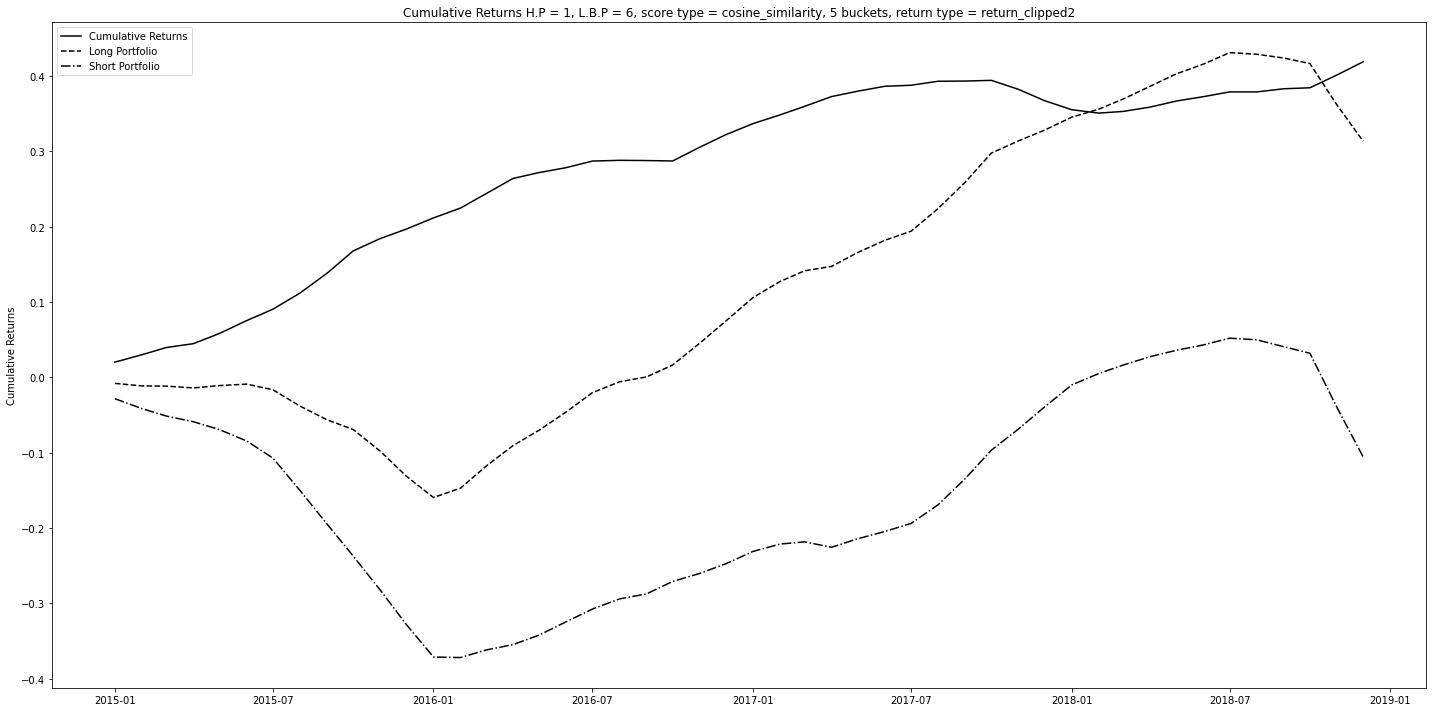

,Value
Sharpe Ratio,3.38
Max Drawdown,-0.05
Hit Rate,85%
CAGR,13.14%
Monthly Returns,103bps
Monthly Vol,106bps


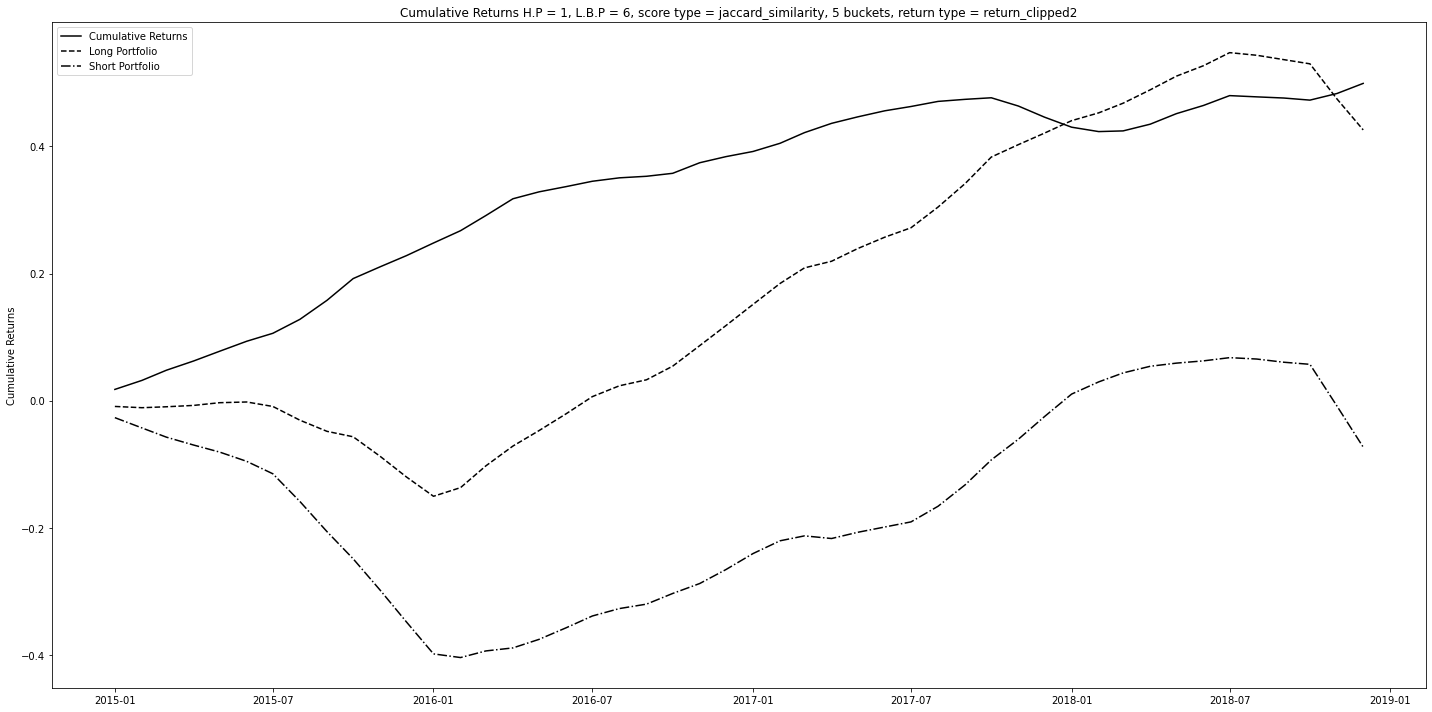

In [9]:
num_bucket = 5
hold_period = 1
history = 6
for score_type in ['cosine_similarity', 'jaccard_similarity']:        
    file_path_req = f'{folder_path}/F_and_H/f{hold_period}_and_h{history}/n_{num_bucket}/{score_type}/ret.parquet'
    portfolio = pq.read_table(file_path_req).to_pandas()
    portfolio = portfolio[(portfolio['date']>=pd.Timestamp('2015-01-01')) & (portfolio['date']<=pd.Timestamp('2018-12-31'))]
    #portfolio = get_monthly_returns(portfolio, hold_period)
    print(f"Running for hold_period: {hold_period}, lookback_period: {history}, num_bucket: {num_bucket}, score_type: {score_type}")
    title = f'H.P = {hold_period}, L.B.P = {history}, score type = {score_type}, {num_bucket} buckets, '
    for return_type in ['return_clipped2']:
        title_req = title + f'return type = {return_type}'
        display(compute_portfolio_metrics(portfolio[return_type], hold_period))
        plot_long_short_cumm_returns(portfolio['long_' + return_type], portfolio['short_' + return_type], portfolio['date'], title=title_req)